In [46]:
from hsemotion.facial_emotions import HSEmotionRecognizer
import cv2
from IPython.display import Video, display
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

device = 'cuda'
import torch
torch.cuda.empty_cache()

In [47]:
def print_emotions(df, video_path):
    #  Dibujar el lineplot
    plt.figure(figsize=(10, 6))
    for col in df.columns[1:]:
        plt.plot(df['frame'], df[col], label=col)

    plt.xlabel('Frame')
    plt.ylabel('Score')
    plt.title('Evolución de los Scores por Frame')
    plt.legend(title='Emoción', loc='upper left')
    plt.grid()
    plt.show()

    display(Video(video_path, embed=True, width=400, height=300))

def process_video(fer, video_path):
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    batch_size = 8  # Número de frames procesados en cada batch
    batch_frames = []
    results = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        # Convertir frame de OpenCV (BGR) a formato RGB para el modelo
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        batch_frames.append(frame_rgb)

        # Procesar cuando el batch está lleno
        if len(batch_frames) == batch_size:
            emotions, scores = fer.predict_multi_emotions(batch_frames)
            for i, emotion in enumerate(emotions):
                # print(f"Frame {frame_count - batch_size + i + 1}: Emoción detectada: {emotion}")
                results.append({"frame": frame_count - batch_size + i + 1, "emotion": emotion, "scores": scores[i]})
            batch_frames = []

    # Procesar los frames restantes
    if batch_frames:
        emotions, scores = fer.predict_multi_emotions(batch_frames)
        for i, emotion in enumerate(emotions):
            # print(f"Frame {frame_count - len(batch_frames) + i + 1}: Emoción detectada: {emotion}")
            results.append({"frame": frame_count - len(batch_frames) + i + 1, "emotion": emotion, "scores": scores[i]})

    cap.release()

    df = pd.DataFrame(results)

    # Leyenda de las emociones
    emotion_legend = {
        0: 'Anger',
        1: 'Contempt',
        2: 'Disgust',
        3: 'Fear',
        4: 'Happiness',
        5: 'Neutral',
        6: 'Sadness',
        7: 'Surprise',
    }

    # Expandir la columna scores en varias columnas
    scores_df = pd.DataFrame(df['scores'].to_list(), columns=[emotion_legend[i] for i in range(len(df['scores'][0]))])
    df_expanded = pd.concat([df['frame'], scores_df], axis=1) 

    return df_expanded

In [48]:
# Inicializar el reconocedor de emociones con el modelo deseado
model_name = 'enet_b0_8_best_afew'  # Se puede elegir entre varios modelos disponibles
fer = HSEmotionRecognizer(model_name=model_name, device=device)

/home/aacastro/.hsemotion/enet_b0_8_best_afew.pt Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [49]:
paths = [
    "/home/aacastro/Alejandro/ACA_MultichanelAI_2025/src/VIDEO/test_happy.mp4",
    "/home/aacastro/Alejandro/ACA_MultichanelAI_2025/src/VIDEO/test_angry.mp4",
    "/home/aacastro/Alejandro/ACA_MultichanelAI_2025/src/VIDEO/test_sad.mp4"
]

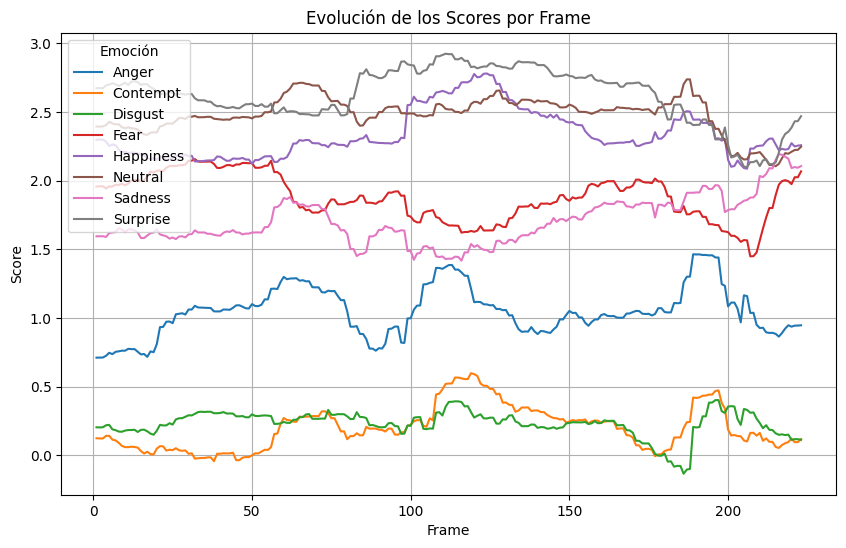

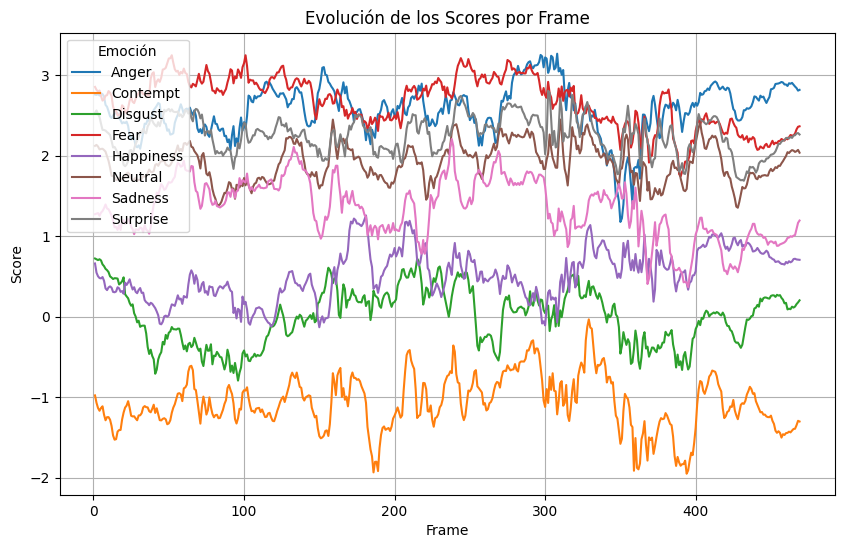

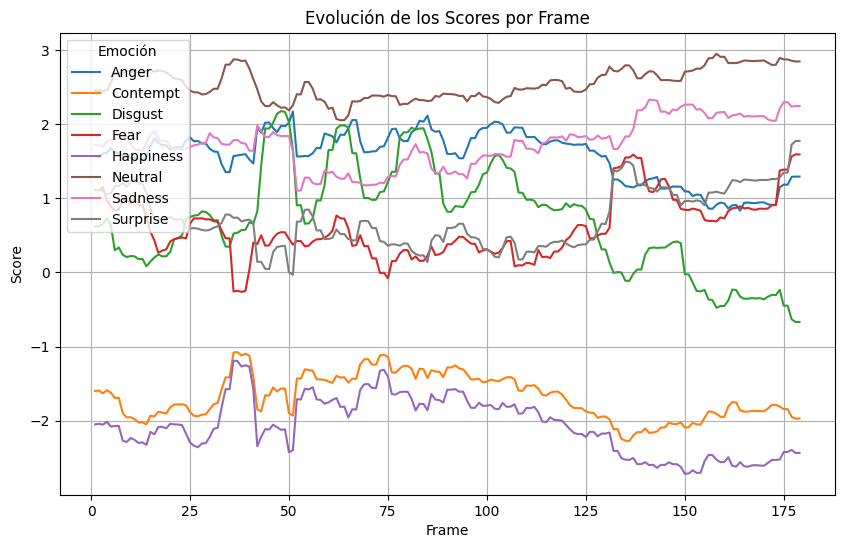

In [50]:
for video_path in paths: 
    df_expanded = process_video(fer, video_path)
    print_emotions(df_expanded, video_path)